In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import shap 

In [2]:
df = pd.read_csv('dataset.csv')
df

,Unnamed: 0,Name,City,INN,reliable,dobro_mail,need_help,https,legal_fee
0,0,Благотворительный фонд социальной поддержки на...,Благовещенск РБ,1,1,1,1,0,1
1,1,Благотворительный фонд помощи тяжело больным д...,Уфа,1,1,1,1,0,1
2,2,Автономная некоммерческая медицинская организа...,Уфа,1,1,1,1,0,1
3,3,"Детский Благотворительный Фонд ""С Любовью""",Уфа,1,1,1,1,1,1
4,4,Благотворительный фонд помощи тяжелобольным де...,Уфа,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...
507,507,"Благотворительный фонд помощи ""Звезда Милосердия""",Москва,0,1,1,1,0,1
508,508,Центр защиты прав СМИ,Воронеж,0,1,1,1,0,1
509,509,Фонд защиты городских животных,Москва,0,1,1,1,0,1
510,510,Благотворительный фонд «РДКМ»,Москва,0,1,1,1,0,1


In [3]:
target = df['reliable']
data = df.drop(['Unnamed: 0', 'reliable', 'Name'], axis=1)

data["City"] = data["City"].astype(str)

In [4]:
encoder = LabelEncoder()
categorical = data.dtypes[data.dtypes=="object"].index.tolist()

data[categorical] = data[categorical].apply(encoder.fit_transform)

In [5]:
dtrain = xgb.DMatrix(data, target)

In [6]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "eval_metric": "auc"
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    verbose_eval=500
)

### Классические меры важности XGBoost

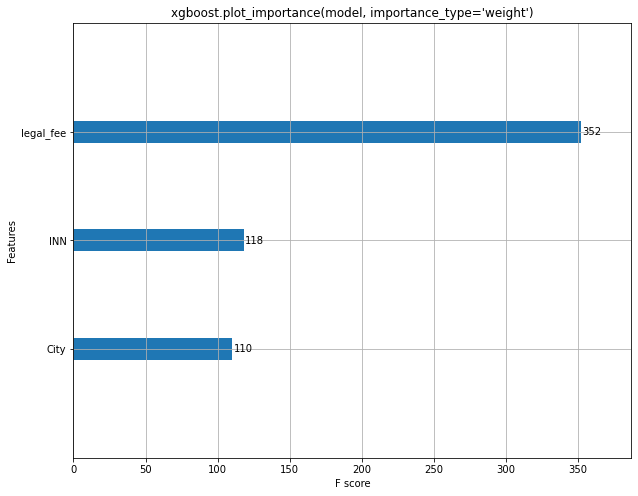

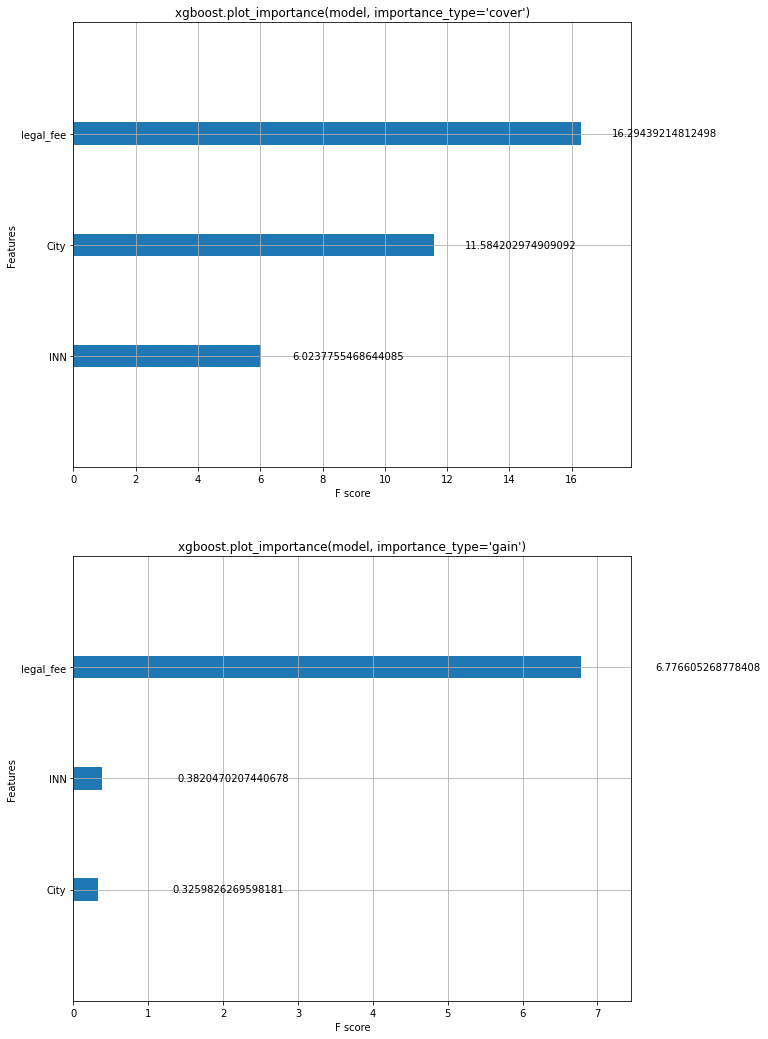

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb.plot_importance(model, ax=ax)
plt.title("xgboost.plot_importance(model, importance_type='weight')")
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 18))
xgb.plot_importance(model, ax=ax[0], importance_type="cover")
ax[0].set_title("xgboost.plot_importance(model, importance_type='cover')")

xgb.plot_importance(model, ax=ax[1], importance_type="gain")
ax[1].set_title("xgboost.plot_importance(model, importance_type='gain')")
plt.show()

Weight - сколько раз признак использовался для разбиения вершины дерева, по всем деревьям.

Cover - количество раз, когда признак используется для разбиения вершины данных, взвешенная на долю наблюдений обучающей выборки, которая проходит через это разбиение. Считается по всем деревьям.

Gain - среднее снижение значения функции потерь при обучении, полученное при данного признака.

### SHAP Summary Plot

In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data, target)

In [9]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], data.iloc[0,:], link="logit"
)

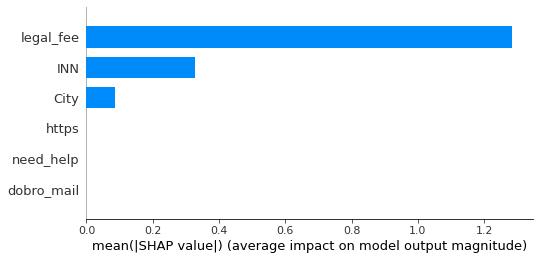

In [10]:
shap.summary_plot(shap_values, data, plot_type="bar", max_display=data.shape[1])

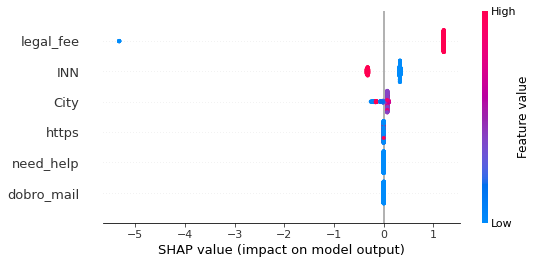

In [11]:
shap.summary_plot(shap_values, data)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


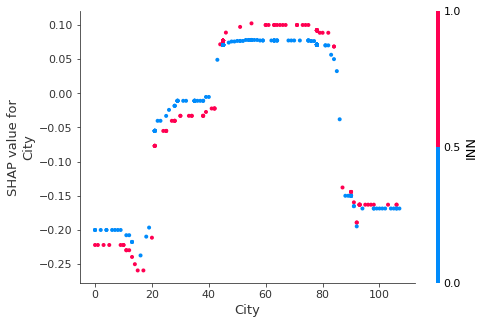

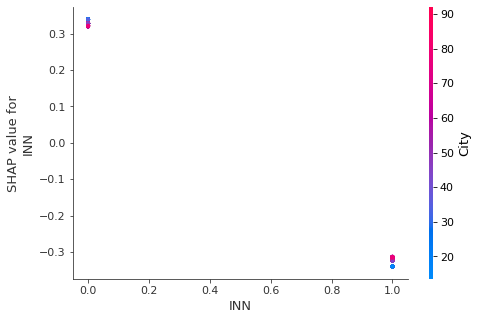

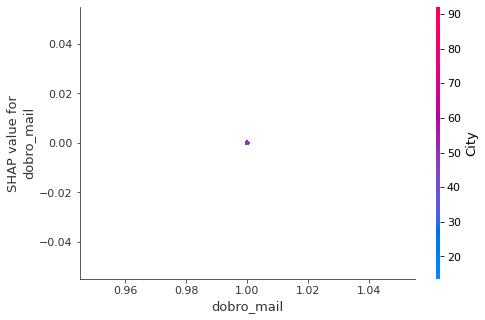

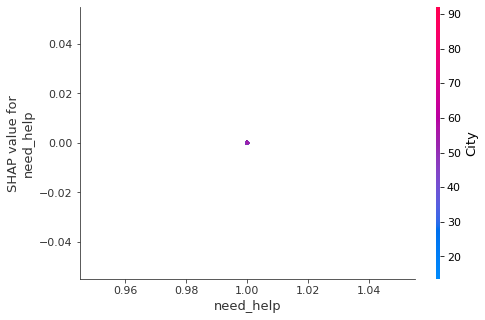

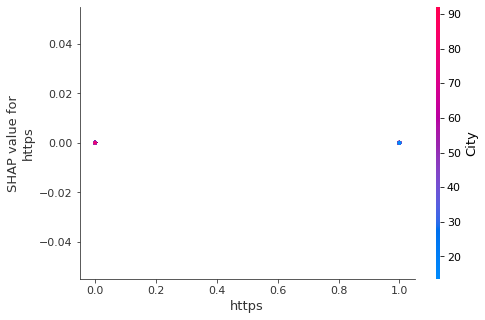

invalid value encountered in true_divide
invalid value encountered in true_divide


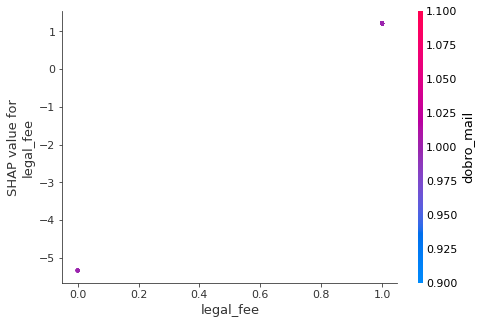

In [12]:
dependence_features = data.columns

for name in dependence_features:
    shap.dependence_plot(name, shap_values, data, display_features=data)

In [17]:
test = pd.read_csv('test2.csv')
test

,Unnamed: 0,Name,City,INN,dobro_mail,need_help,https,legal_fee
0,0,Служба помощи «Милосердие»,Москва,1,1,0,1,1
1,1,Вы в нас нужаетесь,Челябинск,1,0,0,0,0


In [18]:
test[categorical] = test[categorical].apply(encoder.transform)

In [19]:
test.drop(['Unnamed: 0', 'Name'], axis=1, inplace=True)

In [20]:
dtest = xgb.DMatrix(test)
model.predict(dtest)

array([0.9950891, 0.1875508], dtype=float32)